In [1]:
import os
import time
import tejapi
import talib as ta
from talib import abstract
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
import configparser
import re
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
from initialize import ML_stock
from select_1 import sample, column, feature

In [4]:
ml_stock = ML_stock()
ml_stock.ini()
start = '2012-07-01'
end = '2022-07-01'

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [8]:
df = ml_stock.get_fundamental(start, end, [sample[0]], column)
df = ml_stock.calculate_all_technical_indicators(df)
preporc_data = ml_stock.preprocessing(df)

Currently used TEJ API key call quota 486/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 5538329/9223372036854775807 (0.0%)


In [9]:
preporc_data

,coid,mdate,high,low,volume,close,open,Return_Rate_on_Equity_A_percent_Q,MOM,RSI
0,8215,2012-07-02,13.25,13.00,446.0,13.00,13.15,-10.65,0.00,0.000000
1,8215,2012-07-03,13.30,13.10,380.0,13.15,13.30,-10.65,0.00,0.000000
2,8215,2012-07-04,14.05,13.15,1397.0,14.05,13.15,-10.65,0.00,0.000000
3,8215,2012-07-05,14.85,14.25,3727.0,14.45,14.35,-10.65,0.00,0.000000
4,8215,2012-07-06,14.45,13.85,1447.0,14.00,14.35,-10.65,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...
2443,8215,2022-06-27,33.40,32.85,1591.0,33.35,32.95,5.02,-1.75,46.169797
2444,8215,2022-06-28,33.50,32.70,941.0,32.90,33.35,5.02,-1.50,44.053939
2445,8215,2022-06-29,32.55,32.05,1076.0,32.30,32.55,5.02,-2.65,41.333999
2446,8215,2022-06-30,32.30,31.40,2031.0,31.40,32.25,5.02,-3.35,37.585394


In [10]:
data = preporc_data.drop(columns=['mdate', 'coid'])
data

,high,low,volume,close,open,Return_Rate_on_Equity_A_percent_Q,MOM,RSI
0,13.25,13.00,446.0,13.00,13.15,-10.65,0.00,0.000000
1,13.30,13.10,380.0,13.15,13.30,-10.65,0.00,0.000000
2,14.05,13.15,1397.0,14.05,13.15,-10.65,0.00,0.000000
3,14.85,14.25,3727.0,14.45,14.35,-10.65,0.00,0.000000
4,14.45,13.85,1447.0,14.00,14.35,-10.65,0.00,0.000000
...,...,...,...,...,...,...,...,...
2443,33.40,32.85,1591.0,33.35,32.95,5.02,-1.75,46.169797
2444,33.50,32.70,941.0,32.90,33.35,5.02,-1.50,44.053939
2445,32.55,32.05,1076.0,32.30,32.55,5.02,-2.65,41.333999
2446,32.30,31.40,2031.0,31.40,32.25,5.02,-3.35,37.585394


In [11]:
def create_dataset(df, window_size=5):
    df = data

    # features = df[['open', 'high', 'low', 'close', 'volume']].values
    features = df[feature].values
    
    target = df['close'].shift(-1).values  # y變量為隔日收盤價
    target[-1] = target[-2]

    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    t_scaler = StandardScaler()
    target = t_scaler.fit_transform(target.reshape(-1, 1))

    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(features[i:i + window_size])
        y.append(target[i + window_size])

    return np.array(X), np.array(y), t_scaler

In [12]:
X, y, t_scaler = create_dataset(data, 5)

In [13]:
X.shape

(2443, 5, 8)

In [14]:
y.shape

(2443, 1)

In [15]:
split_train = int(len(X) * 0.8)
split_val = int(len(X) * 0.9)
X_train = X[:split_train]
X_val = X[split_train:split_val]
X_test = X[split_val:]

y_train = y[:split_train]
y_val = y[split_train:split_val]
y_test = y[split_val:]

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
# from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

model = Sequential([layers.Input((X_train.shape[1], X_train.shape[2])),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    Dropout(0.2),
                    layers.Dense(32, activation='relu'),
                    Dropout(0.2),
                    layers.Dense(1),
                ])

lr_schedule = ExponentialDecay(
    0.001,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse', metrics=['mae'])

# model.compile(loss='mse',
#               optimizer=Adam(learning_rate=0.001),
#               metrics=['mean_absolute_error'])

model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=early_stopping, batch_size=32)
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=early_stopping)
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,857 (85.38 KB)

 Trainable params: 21,857 (85.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4591 - mae: 0.4997 - val_loss: 0.0371 - val_mae: 0.1480
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1002 - mae: 0.2215 - val_loss: 0.0319 - val_mae: 0.1276
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0712 - mae: 0.1905 - val_loss: 0.0325 - val_mae: 0.1245
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0606 - mae: 0.1743 - val_loss: 0.0251 - val_mae: 0.1127
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0609 - mae: 0.1694 - val_loss: 0.0260 - val_mae: 0.1165
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0503 - mae: 0.1570 - val_loss: 0.0265 - val_mae: 0.1148
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0544 - mae: 0.1631 - val_loss: 0.0255 - val_mae: 0.1169
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0432 - mae: 0.1441 - val_loss: 0.0267 - val_mae: 0.1159
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.050

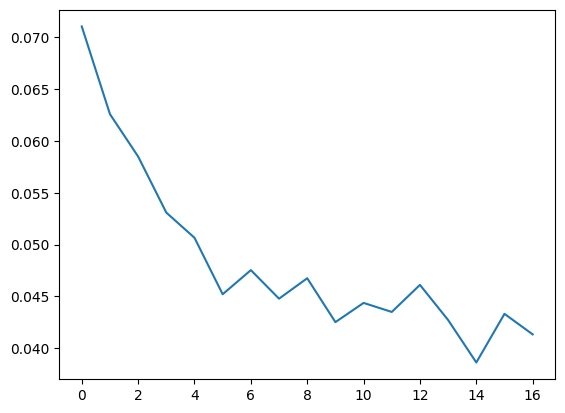

In [17]:
loss_per_epoch = model.history.history['loss']
cut = 2
plt.plot(range(len(loss_per_epoch) - cut), loss_per_epoch[cut:])
plt.show()

In [18]:
y_result = []
y_result = np.append(y_result, model.predict(X_train).flatten())
y_result = np.append(y_result, model.predict(X_val).flatten())
y_result = np.append(y_result, model.predict(X_test).flatten())
y_result, y_result.shape

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step


(array([-1.08284926, -1.07619977, -1.07738173, ...,  1.10174251,
         1.05356073,  0.97945154]),
 (2443,))

In [19]:
y_final = t_scaler.inverse_transform(y_result.reshape(-1, 1)).T
y_final, y_final.shape

(array([[13.65938218, 13.71608614, 13.7060069 , ..., 32.28861832,
         31.87774539, 31.24577481]]),
 (1, 2443))

In [20]:
dates = preporc_data.loc[5:, 'mdate'].values
dates_train = dates[:split_train]
dates_val = dates[split_train:split_val]
dates_test = dates[split_val:]

In [21]:
train_predictions = y_final[0][0 : len(dates_train)]
val_predictions = y_final[0][len(dates_train): len(dates_train)+len(dates_val)]
test_predictions = y_final[0][len(dates_train)+len(dates_val) : ]

In [22]:
y_final[0].shape

(2443,)

In [23]:
y_train_unscaled = t_scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_unscaled = t_scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_unscaled = t_scaler.inverse_transform(y_test.reshape(-1, 1))

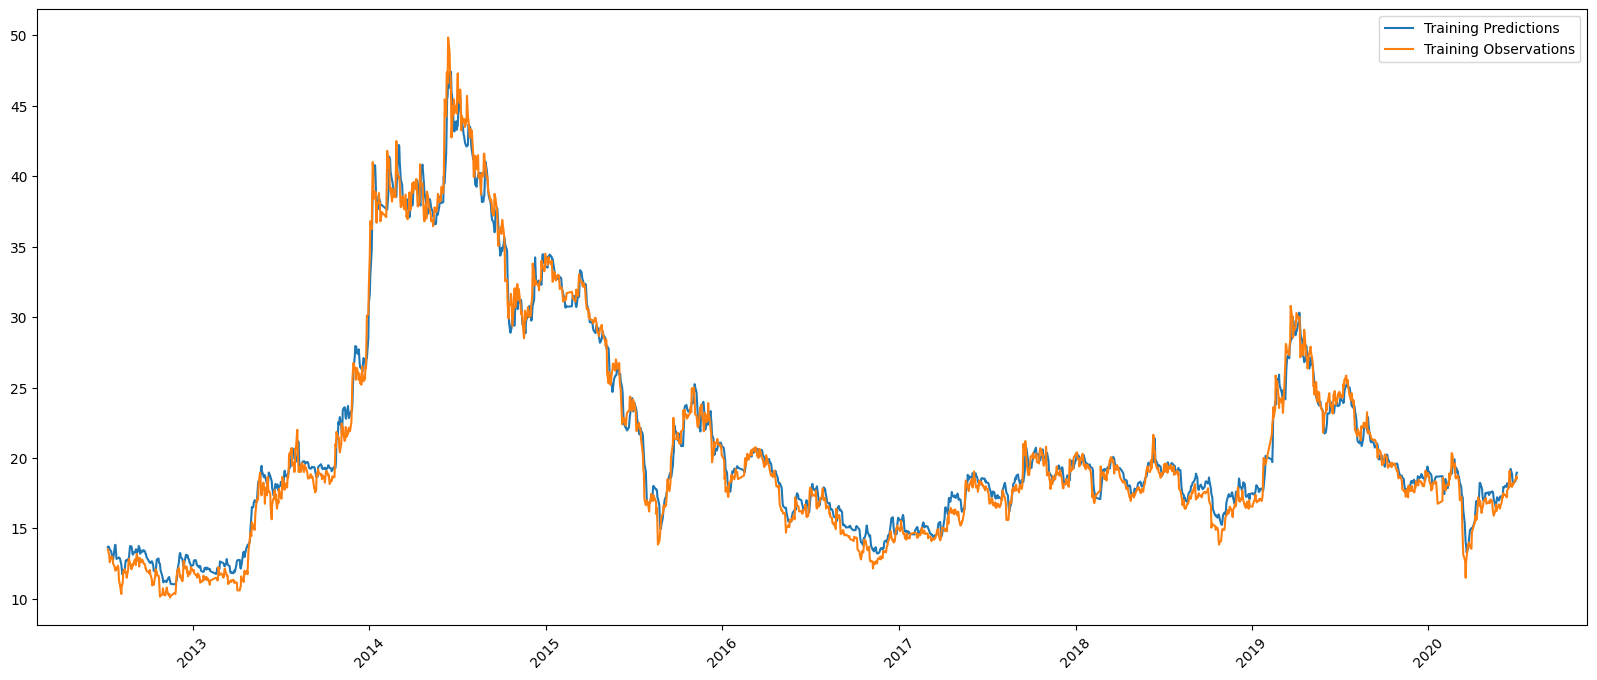

In [24]:
plt.figure(figsize=(20, 8))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train_unscaled)
plt.legend(['Training Predictions', 'Training Observations'])
plt.xticks(rotation = 45)
plt.show()

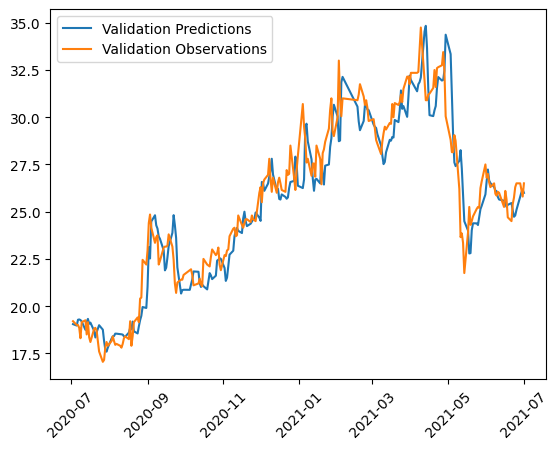

In [25]:
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val_unscaled)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.xticks(rotation = 45)
plt.show()

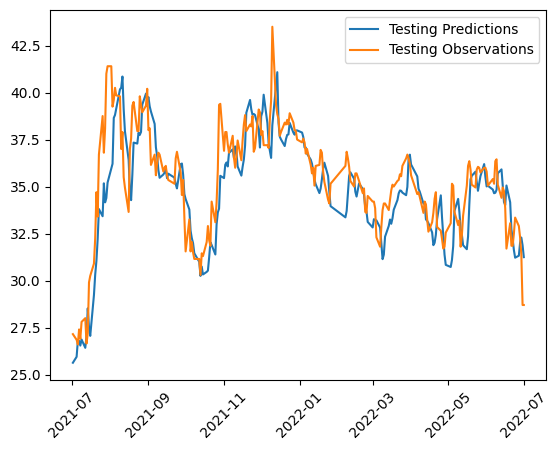

In [26]:
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test_unscaled)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.xticks(rotation = 45)
plt.show()

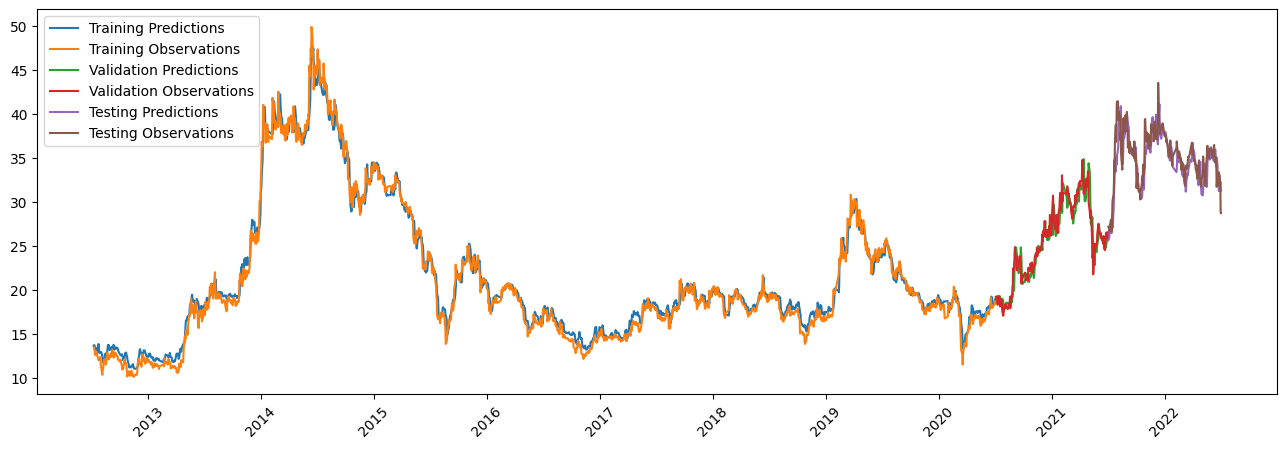

In [27]:
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(5)
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, t_scaler.inverse_transform(y_train.reshape(-1, 1)))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, t_scaler.inverse_transform(y_val.reshape(-1, 1)))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, t_scaler.inverse_transform(y_test.reshape(-1, 1)))
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])
plt.xticks(rotation = 45)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


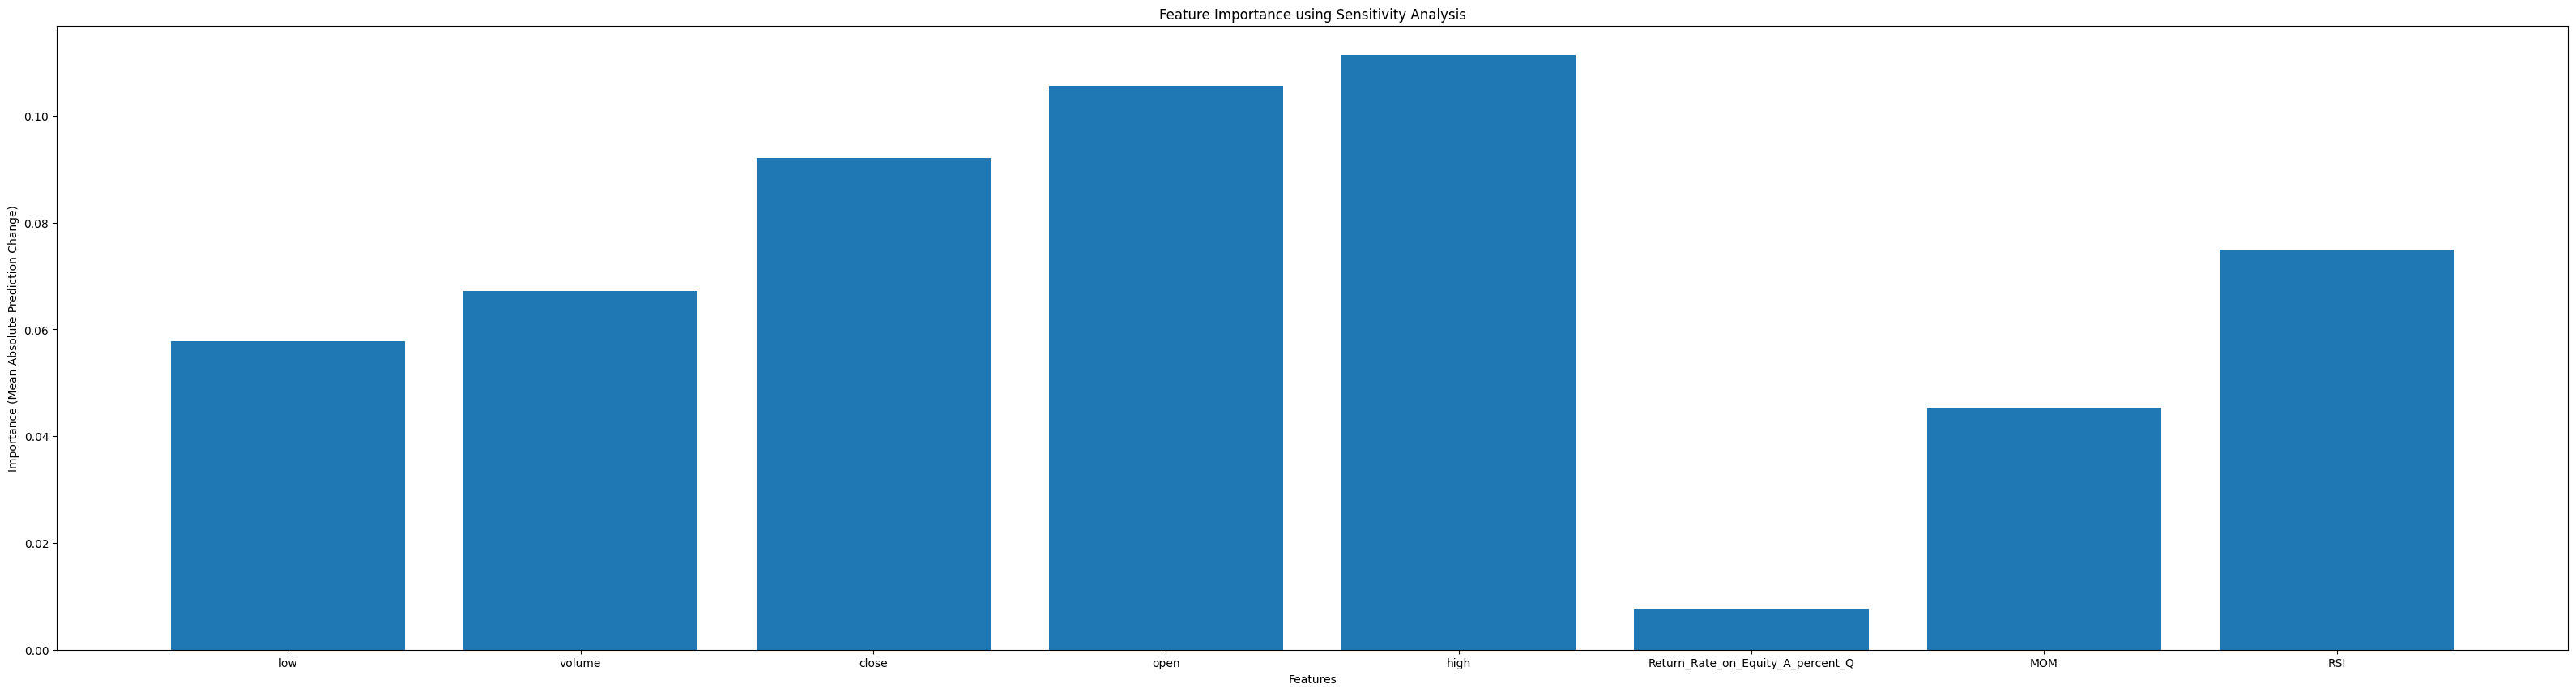

In [28]:
def analyze_feature_importance(model, X, num_samples=1000):
    if not isinstance(X, np.ndarray):
        X = X.to_numpy()
    
    # 隨機選擇樣本
    if X.shape[0] > num_samples:
        indices = np.random.choice(X.shape[0], num_samples, replace=False)
        X = X[indices]
    
    # 取得基準預測
    baseline_pred = model.predict(X)
    
    importances = []
    
    # 對每個特徵進行擾動
    for feature_idx in range(X.shape[2]):
        # 创建扰动数据
        X_perturbed = X.copy()
        X_perturbed[:, :, feature_idx] = np.random.permutation(X_perturbed[:, :, feature_idx])
        
        # 獲取擾動後的預測
        perturbed_pred = model.predict(X_perturbed)
        
        # 計算預測變化的平均值
        importance = np.mean(np.abs(perturbed_pred - baseline_pred))
        importances.append(importance)
    
    return importances

def plot_feature_importance(model, X):
    importances = analyze_feature_importance(model, X)
    
    feature_names = feature
    
    plt.figure(figsize=(40, 10))
    plt.bar(feature_names, importances)
    plt.title('Feature Importance using Sensitivity Analysis')
    plt.xlabel('Features')
    plt.ylabel('Importance (Mean Absolute Prediction Change)')
    plt.show()

plot_feature_importance(model, X_test)

In [29]:
from scipy.signal import savgol_filter

rolling_df = pd.DataFrame({
    'Date': dates_test,
    'Predictions': test_predictions,
    'Observations': y_test_unscaled.reshape(-1)
})
rolling_df.set_index('Date', inplace=True)

In [30]:
rolling_df

,Predictions,Observations
Date,,
2021-07-02,25.628764,27.15
2021-07-05,25.944127,26.85
2021-07-06,26.791840,26.60
2021-07-07,26.793745,27.40
2021-07-08,26.540771,26.90
...,...,...
2022-06-27,31.321866,32.90
2022-06-28,32.005510,32.30
2022-06-29,32.288618,31.40


In [31]:
rolling_df['SMA2'] = rolling_df['Predictions'].rolling(window=2).mean()
rolling_df['SMA20'] = rolling_df['Predictions'].rolling(window=20).mean()

In [32]:
rolling_df['SG_filter'] = savgol_filter(rolling_df['Predictions'], window_length=15, polyorder=3)

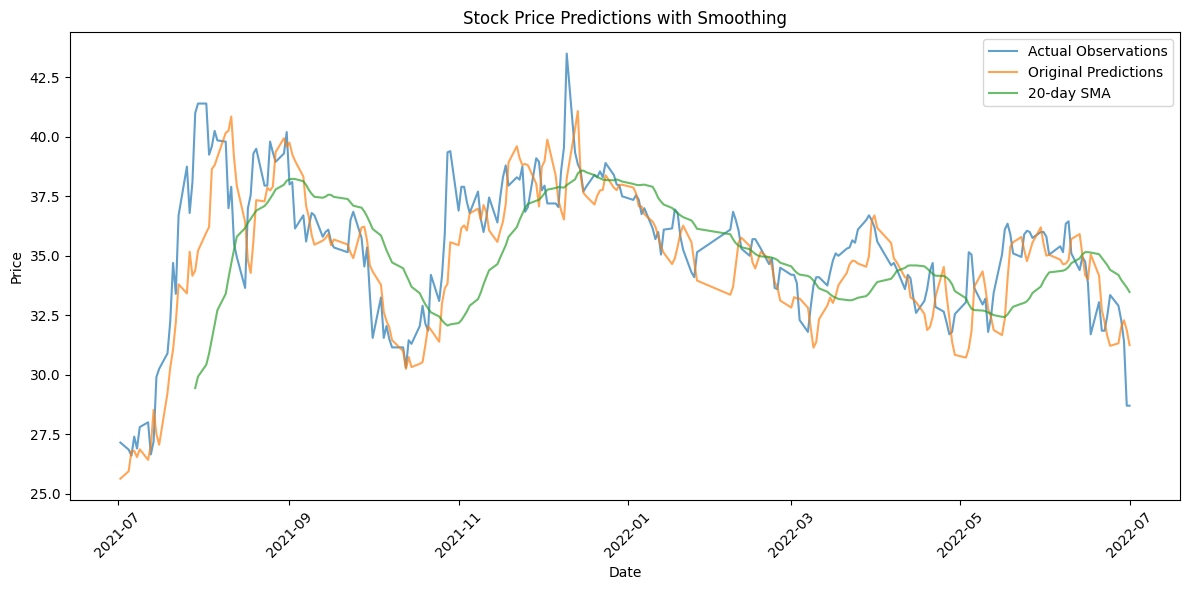

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(rolling_df.index, rolling_df['Observations'], label='Actual Observations', alpha=0.7)
plt.plot(rolling_df.index, rolling_df['Predictions'], label='Original Predictions', alpha=0.7)
# plt.plot(rolling_df.index, rolling_df['SMA2'], label='2-day SMA', alpha=0.7)
plt.plot(rolling_df.index, rolling_df['SMA20'], label='20-day SMA', alpha=0.7)
# plt.plot(rolling_df.index, rolling_df['SG_filter'], label='Savitzky-Golay Filter', alpha=0.7)

plt.title('Stock Price Predictions with Smoothing')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
model.save(f'lstm_{sample[0]}.keras', include_optimizer = False)